# COVID-19-detection-ML-DL
Детектирование наличия COVID-19 либо вирусной пневмонии на рентгеновских снимках легких с помощью алгоритмов машинного и глубокого обучения.

## Оглавление
1) Загрузка необходимых библиотек и инструментов:
- os,
- cv2,
- scikit-image,
- numpy,
- scikit-learn,
- torch.
2) Создание отдельных функций:
- загрузки изображений,
- выделения LBP-признаков,
- разметки примеров.
3) Загрузка и предобработка датасета:
- загрузка изображений,
- выделение LBP-признаков,
- разметка примеров.
4) Построение и оценка моделей на основе классических алгоритмов машинного обучения:
- KNearestNeiborghs,
- DecisionTree,
- RandomForestTree,
- GradientBoostingClassifier.
5) Построение и оценка моделей на основе классических алгоритмов глубокого обучения:
- Многослойный персептрон (Scikit-Learn),
- Многослойный персептрон (Torch).

In [69]:
# Загрузка необходимых библиотек и инструментов
import os # Библиотека для работы с функциями ОС
import cv2 # Библиотека для работы с изображениями
from skimage.feature import local_binary_pattern # Инструмент извлечения LBP-признаков
import numpy as np # Библиотека для математических операций
import matplotlib.pyplot as plt # Библиотека для визуализации данных
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # Матрица ошибок и отчет по классификации
from sklearn.neighbors import KNeighborsClassifier # Метод KNN
from sklearn.tree import DecisionTreeClassifier # Алгоритм DecisionTree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Алгоритмы RandomForestTree и GradientBoostingClassifier
from concurrent.futures import ThreadPoolExecutor # Параллельная реализация процессов
from sklearn.neural_network import MLPClassifier # Многослойный персептрон
import torch as tr # Библиотека машинного и глубокого обучения

In [70]:
# Функция загрузки изображений
def image_load(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(directory,filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
    return images

In [71]:
# Функция выделения LBP-признаков
def lbp_features(image):
    # Извлечение LBP-признаков
    lbp = local_binary_pattern(
        image=image,
        P=16,
        R=1,
        method='uniform'
        )
    # Вычисляем гистограмму признаков
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    # Нормализуем гистограмму
    hist = hist / hist.sum()
    return hist

In [72]:
# Функция подсчета количества примеров в директории
def count_image_files(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            count += 1
    return count

In [73]:
# Функция для параллельной обработки изображений
def process_images_parallel(images, max_workers=None):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        features = list(executor.map(lbp_features, images))
    return features

### Использован следующий [датасет](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/). Для осуществления обучения и проверки моделей необходимо провести предварительную обработку изображений.

In [74]:
# Директории датасета
directories = [
    "Covid19-dataset/train/Normal",
    "Covid19-dataset/train/Viral_Pneumonia",
    "Covid19-dataset/train/Covid",
    "Covid19-dataset/test/Normal",
    "Covid19-dataset/test/Viral_Pneumonia",
    "Covid19-dataset/test/Covid"
]

In [75]:
# Список для сохранения результатов
image_datasets = [None] * len(directories)

In [76]:
# Параллельная загрузка
with ThreadPoolExecutor() as executor:
    futures = []
    for i, directory in enumerate(directories):
        futures.append(executor.submit(image_load, directory))
    
    for i, future in enumerate(futures):
        image_datasets[i] = future.result()

In [77]:
# Загрузка изображений из директорий
images_train_Normal = []
images_train_Normal = image_load(directory=directories[0])
#
images_train_Viral_Pneumonia = []
images_train_Viral_Pneumonia = image_load(directory=directories[1])
#
images_train_Covid = []
images_train_Covid = image_load(directory=directories[2])
#
images_test_Normal = []
images_test_Normal = image_load(directory=directories[3])
#
images_test_Viral_Pneumonia = []
images_test_Viral_Pneumonia = image_load(directory=directories[4])
#
images_test_Covid = []
images_test_Covid = image_load(directory=directories[5])

In [78]:
# Параллельное выделение признаков для обучающих данных
X_train_Normal = []
X_train_Normal = process_images_parallel(images_train_Normal)
#
X_train_Viral_Pneumonia = []
X_train_Viral_Pneumonia = process_images_parallel(images_train_Viral_Pneumonia)
#
X_train_Covid = []
X_train_Covid = process_images_parallel(images_train_Covid)
#
X_train = []
X_train = np.concatenate([X_train_Normal, X_train_Viral_Pneumonia, X_train_Covid])
#
# Параллельное выделение признаков для тестовых данных
X_test_Normal = []
X_test_Normal = process_images_parallel(images_test_Normal)
#
X_test_Viral_Pneumonia = []
X_test_Viral_Pneumonia = process_images_parallel(images_test_Viral_Pneumonia)
#
X_test_Covid = []
X_test_Covid = process_images_parallel(images_test_Covid)
#
X_test = []
X_test = np.concatenate([X_test_Normal, X_test_Viral_Pneumonia, X_test_Covid])

In [79]:
# Разметка примеров
# 'Normal' = 0
# 'Viral_Pneumonia' = 1
# 'Covid' = 2
#
# Количество файлов в директориях датасета
train_normal_count = count_image_files(directories[0])
train_viral_count = count_image_files(directories[1])
train_covid_count = count_image_files(directories[2])
#
test_normal_count = count_image_files(directories[3])
test_viral_count = count_image_files(directories[4])
test_covid_count = count_image_files(directories[5])
#
# Создание массивов меток
y_train_normal = np.zeros(train_normal_count) 
y_train_viral = np.ones(train_viral_count)     
y_train_covid = np.full(train_covid_count, 2)
y_train = np.concatenate([y_train_normal, y_train_viral, y_train_covid])
#
y_test_normal = np.zeros(test_normal_count)
y_test_viral = np.ones(test_viral_count)
y_test_covid = np.full(test_covid_count, 2)
y_test = np.concatenate([y_test_normal, y_test_viral, y_test_covid])

### Обучение и проверка моделей на основе классических алгоритмов машинного обучения (KNearestNeighbors, DecisionTree, RandomForestTree и GradientBoosting)

#### KNearestNeighbors

<Figure size 600x600 with 0 Axes>

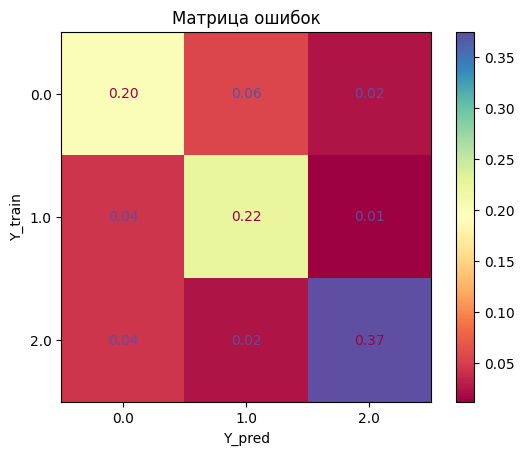

              precision    recall  f1-score   support

      Normal       0.71      0.69      0.70        72
       Viral       0.80      0.74      0.77        76
    Covid-19       0.85      0.91      0.88       103

    accuracy                           0.80       251
   macro avg       0.79      0.78      0.78       251
weighted avg       0.79      0.80      0.79       251



In [80]:
# Обучение и проверка модели на основе KNearestNeighbors
model_KNN = KNeighborsClassifier(n_neighbors=10**1) # инициализация модели на основе KNearestNeighbors
model_KNN.fit(X_train,y_train) # обучение модели
y_pred = model_KNN.predict(X_train) # тестирование модели
cm_model_KNN = confusion_matrix(y_train,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_KNN, display_labels=model_KNN.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_train')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_train, target_names=['Normal','Viral','Covid-19']))

<Figure size 600x600 with 0 Axes>

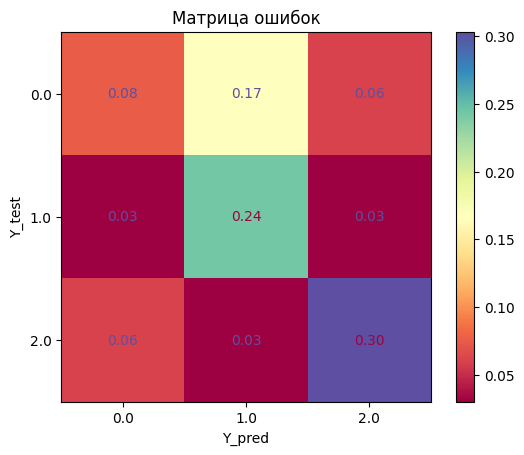

              precision    recall  f1-score   support

      Normal       0.25      0.45      0.32        11
       Viral       0.80      0.55      0.65        29
    Covid-19       0.77      0.77      0.77        26

    accuracy                           0.62        66
   macro avg       0.61      0.59      0.58        66
weighted avg       0.70      0.62      0.64        66



In [81]:
# Тестирование модели на основе KNearestNeighbors
y_pred = model_KNN.predict(X_test) # тестирование модели
cm_model_KNN = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_KNN, display_labels=model_KNN.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_test, target_names=['Normal','Viral','Covid-19']))

#### DecisionTree

<Figure size 600x600 with 0 Axes>

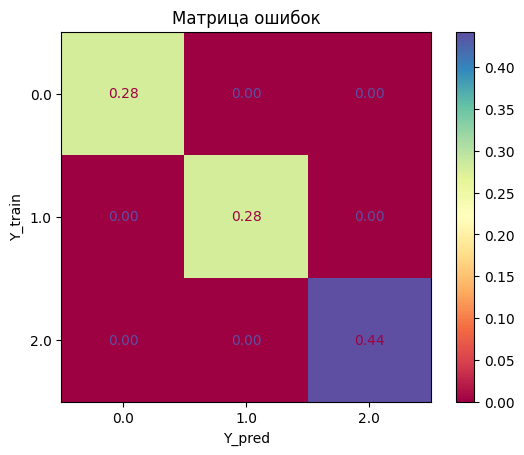

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        70
       Viral       1.00      1.00      1.00        70
    Covid-19       1.00      1.00      1.00       111

    accuracy                           1.00       251
   macro avg       1.00      1.00      1.00       251
weighted avg       1.00      1.00      1.00       251



In [82]:
# Обучение и проверка модели на основе DecisionTree
model_DT = DecisionTreeClassifier(random_state=18) # инициализация модели на основе DecisionTree
model_DT.fit(X_train, y_train) # обучение модели
y_pred = model_DT.predict(X_train) # тестирование модели
cm_model_DT = confusion_matrix(y_train,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_DT, display_labels=model_DT.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_train')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_train, target_names=['Normal','Viral','Covid-19']))

<Figure size 600x600 with 0 Axes>

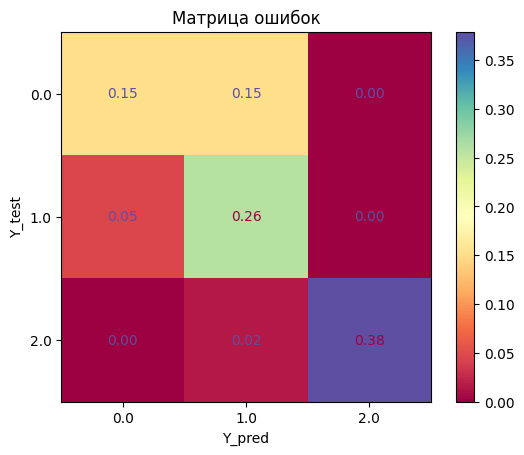

              precision    recall  f1-score   support

      Normal       0.50      0.77      0.61        13
       Viral       0.85      0.61      0.71        28
    Covid-19       0.96      1.00      0.98        25

    accuracy                           0.79        66
   macro avg       0.77      0.79      0.76        66
weighted avg       0.82      0.79      0.79        66



In [83]:
# Тестирование модели на основе DecisionTree
y_pred = model_DT.predict(X_test) # тестирование модели
cm_model_DT = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_DT, display_labels=model_DT.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_test, target_names=['Normal','Viral','Covid-19']))

#### RandomForestTree

<Figure size 600x600 with 0 Axes>

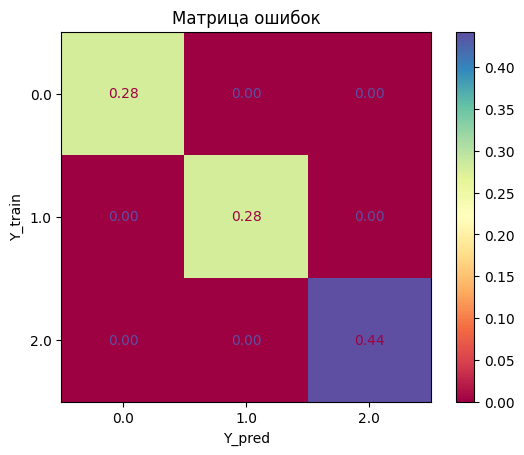

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        70
       Viral       1.00      1.00      1.00        70
    Covid-19       1.00      1.00      1.00       111

    accuracy                           1.00       251
   macro avg       1.00      1.00      1.00       251
weighted avg       1.00      1.00      1.00       251



In [84]:
# Обучение и проверка модели на основе RandomForestTree
model_RFT = RandomForestClassifier(random_state=18) # инициализация модели на основе RandomForestTree
model_RFT.fit(X_train, y_train) # обучение модели
y_pred = model_RFT.predict(X_train) # тестирование модели
cm_model_RFT = confusion_matrix(y_train,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_RFT, display_labels=model_RFT.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_train')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_train, target_names=['Normal','Viral','Covid-19']))

<Figure size 600x600 with 0 Axes>

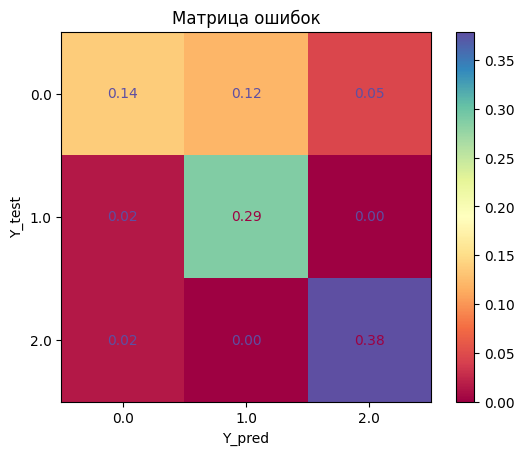

              precision    recall  f1-score   support

      Normal       0.45      0.82      0.58        11
       Viral       0.95      0.70      0.81        27
    Covid-19       0.96      0.89      0.93        28

    accuracy                           0.80        66
   macro avg       0.79      0.80      0.77        66
weighted avg       0.87      0.80      0.82        66



In [85]:
# Тестирование модели на основе RandomForestTree
y_pred = model_RFT.predict(X_test) # тестирование модели
cm_model_RFT = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_RFT, display_labels=model_RFT.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_test, target_names=['Normal','Viral','Covid-19']))

#### GradientBoosting

<Figure size 600x600 with 0 Axes>

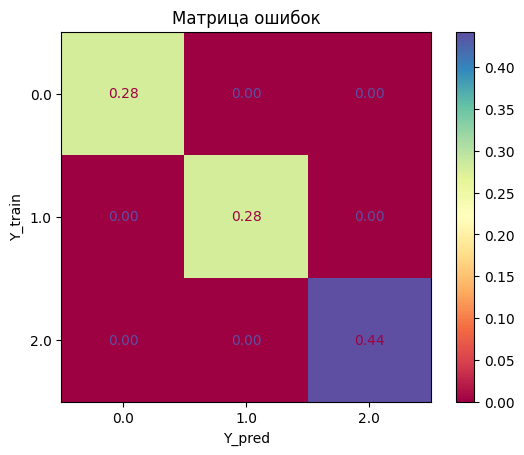

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        70
       Viral       1.00      1.00      1.00        70
    Covid-19       1.00      1.00      1.00       111

    accuracy                           1.00       251
   macro avg       1.00      1.00      1.00       251
weighted avg       1.00      1.00      1.00       251



In [86]:
# Обучение и проверка модели на основе GradientBoosting
model_GB = GradientBoostingClassifier(random_state=18) # Инициализация модели на основе GradientBoosting
model_GB.fit(X_train, y_train) # обучение модели
y_pred = model_GB.predict(X_train) # тестирование модели
cm_model_GB = confusion_matrix(y_train,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_GB, display_labels=model_GB.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_train')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_train, target_names=['Normal','Viral','Covid-19']))

<Figure size 600x600 with 0 Axes>

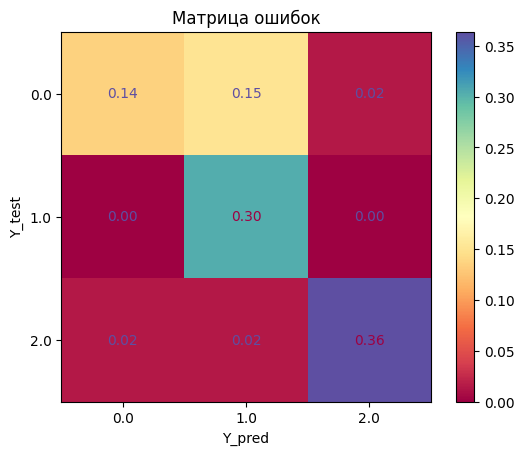

              precision    recall  f1-score   support

      Normal       0.45      0.90      0.60        10
       Viral       1.00      0.65      0.78        31
    Covid-19       0.92      0.96      0.94        25

    accuracy                           0.80        66
   macro avg       0.79      0.84      0.78        66
weighted avg       0.89      0.80      0.82        66



In [87]:
# Тестирование модели на основе GradientBoosting
y_pred = model_GB.predict(X_test) # тестирование модели
cm_model_GB = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_GB, display_labels=model_GB.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_test, target_names=['Normal','Viral','Covid-19']))

### Обучение и проверка моделей на основе нейросетевых алгоритмов машинного обучения (MLP)

#### MLP (scikit-learn)

<Figure size 600x600 with 0 Axes>

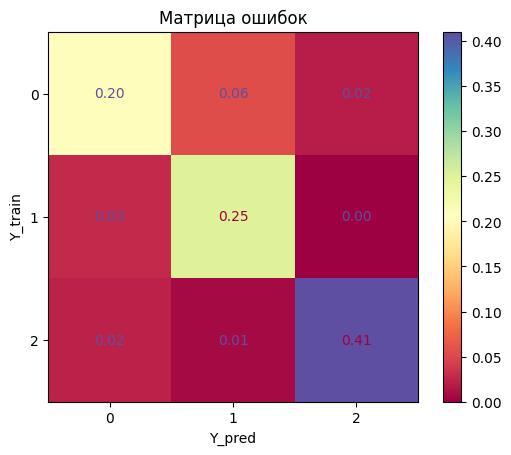

              precision    recall  f1-score   support

      Normal       0.73      0.80      0.76        64
       Viral       0.90      0.80      0.85        79
    Covid-19       0.93      0.95      0.94       108

    accuracy                           0.86       251
   macro avg       0.85      0.85      0.85       251
weighted avg       0.87      0.86      0.86       251



In [91]:
# Обучение и проверка модели на основе многослойного персептрона (scikit-learn)
model_MLP_skl = MLPClassifier(hidden_layer_sizes=(32,16,8),
                              random_state=18,
                              max_iter=10**8) # Инициализация модели на основе многослойного персептрона
model_MLP_skl.fit(X_train,y_train) # обучение модели
y_pred = model_MLP_skl.predict(X_train) # тестирование модели
cm_model_MLP_skl = confusion_matrix(y_train,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_MLP_skl, display_labels=model_MLP_skl.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_train')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_train, target_names=['Normal','Viral','Covid-19']))

<Figure size 600x600 with 0 Axes>

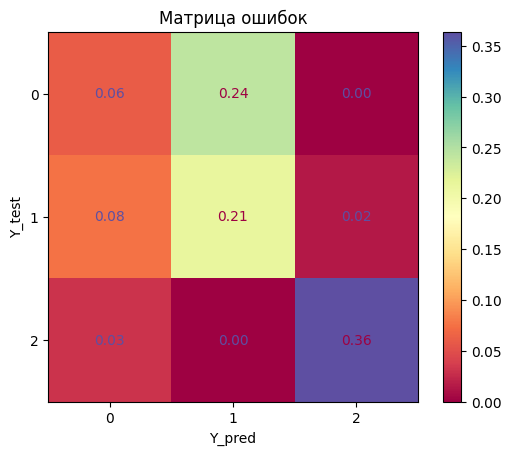

              precision    recall  f1-score   support

      Normal       0.20      0.36      0.26        11
       Viral       0.70      0.47      0.56        30
    Covid-19       0.92      0.96      0.94        25

    accuracy                           0.64        66
   macro avg       0.61      0.60      0.59        66
weighted avg       0.70      0.64      0.65        66



In [92]:
# Тестирование модели на основе многослойного персептрона (scikit-learn)
y_pred = model_MLP_skl.predict(X_test) # тестирование модели
cm_model_MLP_skl = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_MLP_skl, display_labels=model_MLP_skl.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_pred,y_test, target_names=['Normal','Viral','Covid-19']))

#### MLP (torch)

In [90]:
# Преобразование табличных данных в тензоры
X_train = tr.FloatTensor(X_train)
y_train = tr.LongTensor(y_train)
X_test = tr.FloatTensor(X_test)
y_test = tr.LongTensor(y_test)